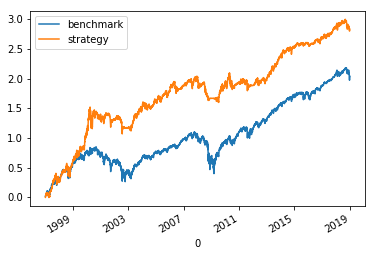

In [2]:
%matplotlib inline

import pandas as pd
data_path = '../Backtests/'
strat = "equity_momentum"
bench = 'SPXTR'
benchmark = pd.read_csv("{}{}.csv".format(data_path, bench), index_col=0, header=None, parse_dates=True)
strategy = pd.read_csv("{}{}.csv".format(data_path, strat), index_col=0, header=None, parse_dates=True)

first_date = pd.Series([benchmark.index[0], strategy.index[0]]).max()
benchmark = benchmark[first_date:]
strategy = strategy[first_date:]

benchmark = benchmark.reindex(strategy.index).ffill()

benchmark_perc_returns = benchmark.diff()/benchmark.shift(1)
strategy_perc_returns = strategy.diff()/strategy.shift(1)

benchmark_cum_returns = benchmark_perc_returns.cumsum()
strategy_cum_returns = strategy_perc_returns.cumsum()
both_cum_returns = pd.concat([benchmark_cum_returns, strategy_cum_returns], axis=1)
both_cum_returns.columns=['benchmark', 'strategy']
both_cum_returns.plot()

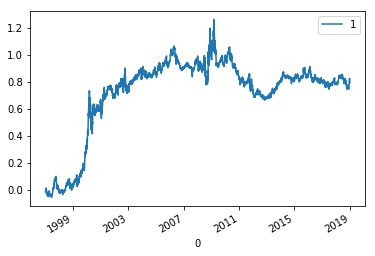

In [3]:
diff_cum_returns = strategy_cum_returns - benchmark_cum_returns
diff_cum_returns.plot()

In [26]:
strategy_perc_returns.mean()*256

1    0.124743
dtype: float64

In [27]:
benchmark_perc_returns.mean()*256

1    0.094309
dtype: float64

In [28]:
strategy_perc_returns.std()*16

1    0.189826
dtype: float64

In [29]:
benchmark_perc_returns.std()*16

1    0.192621
dtype: float64

In [30]:
def simple_sharpe_ratio(perc_returns):
    return (perc_returns.mean()*256) / (perc_returns.std()*16)

In [31]:
simple_sharpe_ratio(strategy_perc_returns)

1    0.657144
dtype: float64

In [32]:
simple_sharpe_ratio(benchmark_perc_returns)

1    0.489609
dtype: float64

In [33]:
adjusted_benchmark_perc_returns = benchmark_perc_returns * strategy_perc_returns.std() / benchmark_perc_returns.std()

adjusted_benchmark_cum_returns = adjusted_benchmark_perc_returns.cumsum()

diff_cum_returns = strategy_cum_returns - adjusted_benchmark_cum_returns
diff_returns = diff_cum_returns.diff()
diff_returns.mean()*256

1    0.032538
dtype: float64

In [34]:
from scipy.stats import ttest_rel
ttest_rel(strategy_perc_returns, adjusted_benchmark_perc_returns, nan_policy='omit')

Ttest_relResult(statistic=masked_array(data = [1.0347721604748643],
             mask = [False],
       fill_value = 1e+20)
, pvalue=masked_array(data = 0.30082053402226544,
             mask = False,
       fill_value = 1e+20)
)

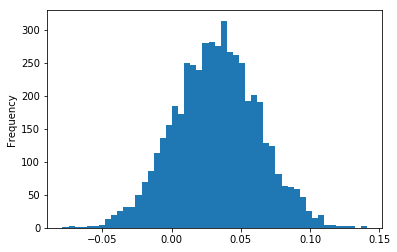

In [35]:
import numpy as np

monte_carlo_runs = 5000 # make this larger if your computer can cope
length_returns = len(diff_returns.index)
bootstraps = [[int(np.random.uniform(high=length_returns)) for _not_used1 in range(length_returns)] for _not_used2 in range(monte_carlo_runs)]

def average_given_bootstrap(one_bootstrap, diff_returns):
   subset_returns = diff_returns.iloc[one_bootstrap]
   average_for_bootstrap = np.float(subset_returns.mean()*256)
   return average_for_bootstrap

bootstrapped_return_differences = [average_given_bootstrap(one_bootstrap, diff_returns) for one_bootstrap in bootstraps]

bootstrapped_return_differences = pd.Series(bootstrapped_return_differences)

bootstrapped_return_differences.plot.hist(bins=50)

In [36]:
sum(bootstrapped_return_differences<0)/float(len(bootstrapped_return_differences))

0.1466

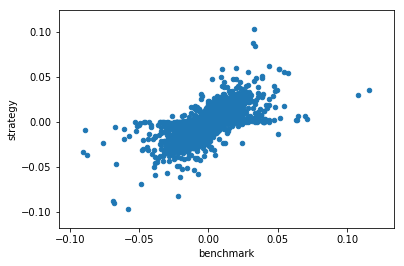

In [37]:
both_returns = pd.concat([strategy_perc_returns, benchmark_perc_returns], axis=1)
both_returns.columns = ['strategy', 'benchmark']


both_returns.plot.scatter(x="benchmark", y="strategy")


In [38]:
import statsmodels.formula.api as smf

lm = smf.ols(formula='strategy ~ benchmark', data=both_returns).fit()
lm.params

Intercept    0.000227
benchmark    0.706171
dtype: float64

In [39]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strategy   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     5840.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        07:47:09   Log-Likelihood:                 18687.
No. Observations:                5536   AIC:                        -3.737e+04
Df Residuals:                    5534   BIC:                        -3.736e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      2.041      0.041    8.97e-06       0.000
benchmark      0.7062      0.009     76.422      0.000       0.688       0.724
==============================================================================
Omnibus:                      921.677   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17845.374
Skew:                          -0.145   Prob(JB):                         0.00
Kurtosis:                      11.791   Cond. No.                         83.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
from scipy.stats import ttest_ind
split_date = pd.datetime(2006,1,1)
ttest_ind(diff_returns[diff_returns.index<split_date], diff_returns[diff_returns.index>=split_date], nan_policy='omit')

Ttest_indResult(statistic=masked_array(data = [1.6351376708112633],
             mask = [False],
       fill_value = 1e+20)
, pvalue=masked_array(data = 0.10207707408174886,
             mask = False,
       fill_value = 1e+20)
)

In [41]:
strategy_weight = pd.Series([0.0]*len(strategy_perc_returns), index=strategy_perc_returns.index)
benchmark_weight = pd.Series([0.0]*len(benchmark_perc_returns), index=benchmark_perc_returns.index)

strategy_weight[strategy_weight.index<split_date] = 1.0
benchmark_weight[benchmark_weight.index<split_date]=0.0

strategy_weight[strategy_weight.index>=split_date] = 0.5
benchmark_weight[benchmark_weight.index>=split_date]=0.5

both_weights = pd.concat([strategy_weight,benchmark_weight], axis=1)
both_returns = pd.concat([strategy_perc_returns, benchmark_perc_returns], axis=1)
both_weights.columns = both_returns.columns = ['strategy', 'benchmark']

implicit_fit_returns = both_weights*both_returns
implicit_fit_returns = implicit_fit_returns.sum(axis=1)


C:\ProgramData\Anaconda3_new\envs\zip35\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,halflife=640.0,adjust=True,min_periods=0).mean()
  if __name__ == '__main__':


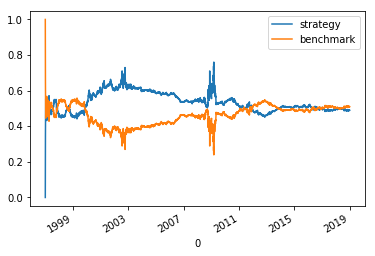

In [42]:
rolling_means = pd.ewma(both_returns, halflife = 2.5*256)
rolling_means = rolling_means + (0.16/256)
rolling_means[rolling_means<0]=0.000001 
total_mean_to_normalise = rolling_means.sum(axis=1)
total_mean_to_normalise = pd.concat([total_mean_to_normalise]*2, axis=1)
total_mean_to_normalise.columns = rolling_means.columns
rolling_weights = rolling_means / total_mean_to_normalise
rolling_weights.plot()


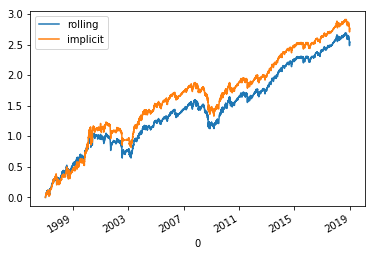

In [43]:
rolling_fit_returns = rolling_weights*both_returns
rolling_fit_returns = rolling_fit_returns.sum(axis=1)

compare_returns = pd.concat([rolling_fit_returns, implicit_fit_returns], axis=1)
compare_returns.columns = ['rolling', 'implicit']
compare_returns.cumsum().plot()


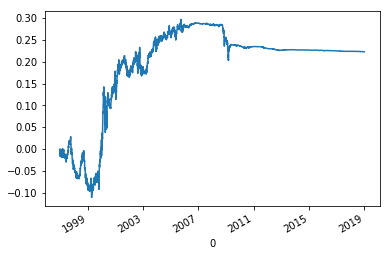

In [44]:
diff_compare = implicit_fit_returns - rolling_fit_returns
diff_compare.cumsum().plot()

In [45]:
simple_sharpe_ratio(rolling_fit_returns)

0.669280152423306

In [46]:
simple_sharpe_ratio(implicit_fit_returns)

0.6708715830455622